# CS 451 - Final Project
## Vehicle Safety Analysis with MCP

### Dataset: US Accidents (3.0 million records)
Link to dataset: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents

### Project Description:

This project consists of an exploratory data analysis, and prediction modelling for vehicle accidents in the United States. The dataset contains information about various accidents, including their severity, location, weather conditions, and other relevant factors. The goal of this project is to get a feel for the data, extract interesting trends and insights, and build machine learning models to predict accident severity and congestion duration based on the available features. Then, an MCP server is built that can query these models, along with other tools, to interact with the dataset.

### Setup:
- Ensure you have spark 4.0.0 and pyspark installed.
- Download the dataset from the above link and place it in the same directory as this notebook
- Unzip the dataset to extract `US_Accidents_March23.csv`

### Authors: Hargun Singh Mujral, Kushaldeep Mujral

Citations: 
Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.



In [1]:
!pip install pyspark plotly

In [3]:
import os
import sys

# Remove SPARK_REMOTE entirely to disable Spark Connect
os.environ.pop("SPARK_REMOTE", None)

import findspark

# Change to path on your local machine.
os.environ["SPARK_HOME"] = "/Users/james/Downloads/spark-4.0.1-bin-hadoop3"
findspark.init()

from pyspark.sql import SparkSession, functions as F, Window
from pyspark.sql.functions import broadcast

py = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = py
os.environ["PYSPARK_PYTHON"] = py

spark = (
    SparkSession.builder
    .appName("A3")
    .master("local[*]")
    .config("spark.driver.memory", "8g")           
    .config("spark.sql.shuffle.partitions", "400")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.pyspark.driver.python", py)
    .config("spark.pyspark.python", py)
    .config("spark.executorEnv.PYSPARK_PYTHON", py)
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

sc = spark.sparkContext
print("Spark:", spark.version)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/15 04:20:38 WARN Utils: Your hostname, KushBook.local, resolves to a loopback address: 127.0.0.1; using 172.20.10.3 instead (on interface en0)
25/12/15 04:20:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/15 04:20:38 WARN Utils: Your hostname, KushBook.local, resolves to a loopback address: 127.0.0.1; using 172.20.10.3 instead (on interface en0)
25/12/15 04:20:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setL

Spark: 4.0.1


Loading the dataset, and printing key details about it.

In [4]:
from pyspark.sql import SparkSession


dataset_path = "US_Accidents_March23.csv"

data = sc.textFile(dataset_path)
header = data.first()

data = (
    data
    .filter(lambda line: line != header)  
    .map(lambda line: line.split(","))
)

# data cleaning
data = (
    data
    .filter(lambda fields: len(fields) == len(header.split(",")))  
    .map(lambda fields: [f.strip() for f in fields]) 
)

print("Columns:", header.split(","))
print("Total records:", data.count())
print("Sample record:", data.first())

Columns: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


Total records: 7728394
Sample record: ['A-1', 'Source2', '3', '2016-02-08 05:46:00', '2016-02-08 11:00:00', '39.865147', '-84.058723', '', '', '0.01', 'Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.', 'I-70 E', 'Dayton', 'Montgomery', 'OH', '45424', 'US', 'US/Eastern', 'KFFO', '2016-02-08 05:58:00', '36.9', '', '91.0', '29.68', '10.0', 'Calm', '', '0.02', 'Light Rain', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'Night', 'Night', 'Night', 'Night']


## Exploratory Data Analysis (EDA)

1. Count of accidents per state 
-> state map with accident ranking.

In [ ]:
import plotly.express as px
import numpy as np

# Exploratory analysis
# 1. Count accidents by state
# -> create a map with colored states based on accident counts from blue to red

# Columns: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

accidents_by_state = (
    data
    .map(lambda fields: (fields[14], 1))  # State is at index 14
    .reduceByKey(lambda a, b: a + b)
)
accidents_by_state_df = accidents_by_state.toDF(["State", "Accident_Count"]).toPandas()
accidents_by_state_df["log_count"] = np.log10(accidents_by_state_df["Accident_Count"])


fig = px.choropleth(
    accidents_by_state_df,
    locations="State",
    locationmode="USA-states",
    color="log_count",
    color_continuous_scale="RdBu_r",  # blue → red
    scope="usa",
    title="Number of Traffic Accidents by State between 2016-2023",  
    labels={"log_count": "Number of Accidents"},
)

tick_vals_actual = [1e3, 1e4, 1e5, 1e6]
tick_vals_log = np.log10(tick_vals_actual)

fig.update_layout(
    coloraxis_colorbar=dict(
        title="Accidents",
        tickmode="array",
        tickvals=tick_vals_log,
        ticktext=[f"{int(v):,}" for v in tick_vals_actual]
    )
)

fig.show()



2. Find the top cities with the most accidents
  -> create a bar chart to visualize the top cities

In [18]:
top_cities = (
    data
    .map(lambda fields: (
        (fields[12].strip()) + ", " + (fields[14].strip()), 1
    )) 
    .reduceByKey(lambda a, b: a + b)
    .sortBy(lambda x: x[1], ascending=False)
).take(10)

top_cities_df = spark.createDataFrame(top_cities, ["City", "Accident_Count"]).toPandas()
fig2 = px.bar(
    top_cities_df,
    x="City",
    y="Accident_Count",
    title="Top 10 Cities with Most Traffic Accidents (2016-2023)",
    labels={"Accident_Count": "Number of Accidents", "City": "City"},
)
fig2.show()


3. Heatmap of accident locations
    -> Based on latitude and longitude data, interesting highway patterns to notice.

In [63]:

import pandas as pd
import plotly.express as px

pts = (
    data
    .map(lambda f: (float(f[5]), float(f[6])))
    .sample(False, 0.02, seed=42)  # 2% sample
    .take(1_000_000)
)

df_pts = pd.DataFrame(pts, columns=["lat", "lon"])

fig = px.density_map(   
    df_pts,
    lat="lat",
    lon="lon",
    radius=2,  
    zoom=2.8,
    center={"lat": 39.5, "lon": -98.35},  # approx US center
    map_style="carto-positron",
    title="Accident Density Heatmap (Start_Lat / Start_Lng)",
    color_continuous_scale="Viridis"
)

fig.show()


4. Matrix of days of week vs hours of day with accident counts
   -> to see when accidents are most likely to occur.

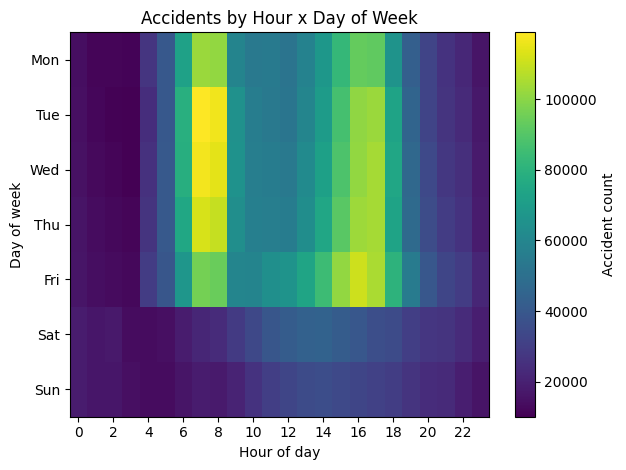

In [5]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEV = 2
START_TIME = 3
WEATHER = 28
VIS = 24

def parse_time(s):
    try:
        t = dt.datetime.strptime(s[:19], "%Y-%m-%d %H:%M:%S")
        return t
    except:
        return None

hourly_counts = (
    data
    .filter(lambda f: f[START_TIME] not in (None, ""))
    .map(lambda f: parse_time(f[START_TIME]))
    .filter(lambda t: t is not None)
    .map(lambda t: ((t.weekday(), t.hour), 1))  
    .reduceByKey(lambda a, b: a + b)
    .collect()
)

mat = np.zeros((7, 24), dtype=int)
for (day, hour), c in hourly_counts:
    mat[day, hour] = c

plt.figure()
plt.imshow(mat, aspect="auto")
plt.yticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xticks(range(0,24,2), [str(h) for h in range(0,24,2)])
plt.xlabel("Hour of day")
plt.ylabel("Day of week")
plt.title("Accidents by Hour x Day of Week")
plt.colorbar(label="Accident count")
plt.tight_layout()
plt.show()


5. Congestion analysis
    - Distribution of congestion durations caused by accidents.
    - Average congestion duration by accident severity.
    - Correlation between congestion duration and accident distance.

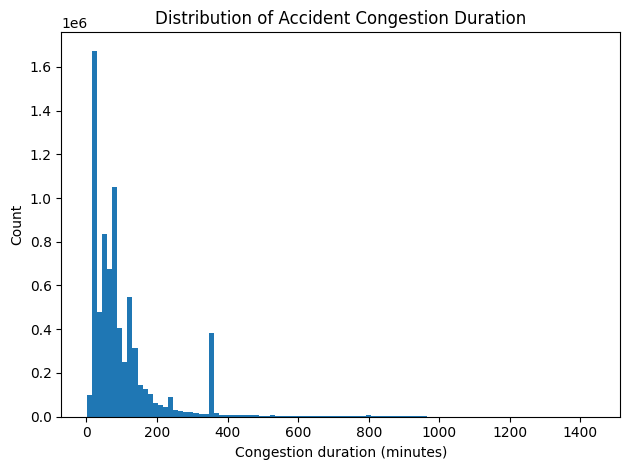

25/12/14 08:45:19 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:131)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:700)
	at org.apache.spark.storage.BlockManagerMasterE

In [64]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

START_IDX = 3
END_IDX = 4
SEV_IDX = 2
DIST_IDX = 9

congestion_rows = (
    data
    .map(lambda f: (
        int(f[SEV_IDX]),
        parse_time(f[START_IDX]),
        parse_time(f[END_IDX]),
        float(f[DIST_IDX])
    ))
    .map(lambda x: (
        x[0],                                # severity, duration, distance
        (x[2] - x[1]).total_seconds() / 60,  
        x[3]                                  
    ))
    .filter(lambda x: 0 < x[1] < 24*60)       # drop extreme outliers (>24h)
)

congestion_df = pd.DataFrame(congestion_rows.collect(), columns=["Severity", "Duration_Min", "Distance_mi"])

plt.figure()
plt.hist(congestion_df["Duration_Min"], bins=100)
plt.xlabel("Congestion duration (minutes)")
plt.ylabel("Count")
plt.title("Distribution of Accident Congestion Duration")
plt.tight_layout()
plt.show()

In [53]:
# average congestion duration by severity
avg_duration_by_severity = (
    data
    .map(lambda f: (
        int(f[SEV_IDX]),
        parse_time(f[START_IDX]),
        parse_time(f[END_IDX]),
    ))
    .map(lambda x: (
        x[0],                                # severity, duration, distance
        (x[2] - x[1]).total_seconds() / 60,  
    ))
    .filter(lambda x: 0 < x[1] < 24*60)       # drop extreme outliers (>24h)
    .map(lambda x: (x[0], (x[1], 1)))        # (severity, (duration, count))
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))  # sum durations and counts
    .map(lambda x: (x[0], x[1][0] / x[1][1]))  # average duration
    .collect()
)

for severity, avg_duration in sorted(avg_duration_by_severity):
    print(f"Severity {severity}: Average Congestion Duration = {avg_duration:.2f} minutes")

Severity 1: Average Congestion Duration = 45.73 minutes
Severity 2: Average Congestion Duration = 114.67 minutes
Severity 3: Average Congestion Duration = 67.78 minutes
Severity 4: Average Congestion Duration = 185.46 minutes


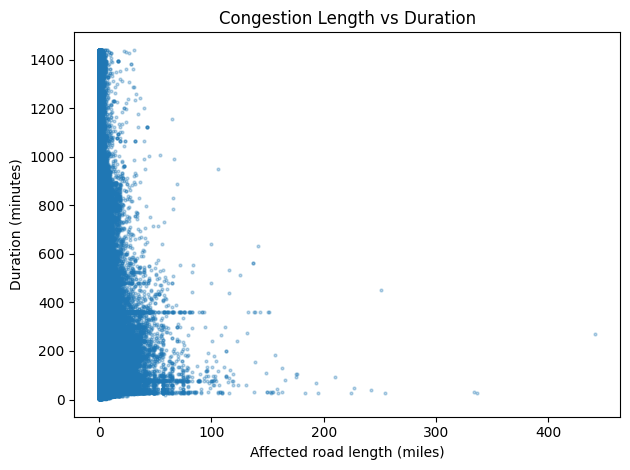

In [62]:
plt.figure()
plt.scatter(congestion_df["Distance_mi"], congestion_df["Duration_Min"], alpha=0.3, s=4)
plt.xlabel("Affected road length (miles)")
plt.ylabel("Duration (minutes)")
plt.title("Congestion Length vs Duration")
plt.tight_layout()
plt.show()


## Predictive Modeling

Training a Logistic Regression model to predict congestion and severity based on the following features:
- Weather
- Visibility
- Time of Day 
- Day of the Week
- Road Features
- State
etc.

In [ ]:
SEV_IDX = 2
START_IDX = 3
END_IDX = 4
DIST_IDX = 9

TEMP_IDX = 20
WIND_CHILL_IDX = 21
HUMIDITY_IDX = 22
PRESSURE_IDX = 23
VISIBILITY_IDX = 24
WIND_IDX = 26
PRECIPITATION_IDX = 27

SUN_IDX = 41  

JUNCTION_IDX = 33
SIGNAL_IDX = 40
CROSSING_IDX = 31
ROUND_IDX = 36
RAIL_IDX = 35
STOP_IDX = 38
CALM_IDX = 39
STATE_IDX = 14

# Columns: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
# Sample record: ['A-1', 'Source2', '3', '2016-02-08 05:46:00', '2016-02-08 11:00:00', '39.865147', '-84.058723', '', '', '0.01', 'Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.', 'I-70 E', 'Dayton', 'Montgomery', 'OH', '45424', 'US', 'US/Eastern', 'KFFO', '2016-02-08 05:58:00', '36.9', '', '91.0', '29.68', '10.0', 'Calm', '', '0.02', 'Light Rain', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'Night', 'Night', 'Night', 'Night']

def is_true(val):
    return val.strip().lower() == "true" or val.strip().lower() == "1"

def to_float(x):
    try:
        return float(x)
    except:
        return None

def to_int(x):
    try:
        return int(x)
    except:
        return None

rows = (
    data
    .filter(lambda f: f[START_IDX] not in (None,"") and f[END_IDX] not in (None,""))
    .map(lambda f: (
        to_int(f[SEV_IDX]),
        parse_time(f[START_IDX]),
        parse_time(f[END_IDX]),
        to_float(f[DIST_IDX]),

        to_float(f[TEMP_IDX]),
        to_float(f[WIND_CHILL_IDX]),
        to_float(f[HUMIDITY_IDX]),
        to_float(f[PRESSURE_IDX]),
        to_float(f[VISIBILITY_IDX]),
        to_float(f[WIND_IDX]),
        to_float(f[PRECIPITATION_IDX]),

        f[SUN_IDX],
        is_true(f[JUNCTION_IDX]),
        is_true(f[SIGNAL_IDX]),
        is_true(f[CROSSING_IDX]),
        is_true(f[ROUND_IDX]),
        is_true(f[RAIL_IDX]),
        is_true(f[STOP_IDX]),
        is_true(f[CALM_IDX]),

        f[STATE_IDX]
    ))
    .map(lambda x: (
        x[0],                                # Severity
        (x[2] - x[1]).total_seconds() / 60,  # Duration (min)
        x[1].hour,                           # Hour
        x[3],                                # Distance
        x[4], x[5], x[6], x[7], x[8], x[9], x[10],  # weather
        1 if x[11] == "Night" else 0,        # Night
        x[12], x[13], x[14], x[15], x[16], x[17], x[18],  # road features
        x[19]                               # State
    ))
    .collect()
)

df = pd.DataFrame(rows, columns=[
    "Severity", "Duration_Min", "Hour", "Distance",
    "Temp", "Wind_Chill", "Humidity", "Pressure",
    "Visibility", "Wind", "Precip",
    "Night",
    "Junction", "Signal", "Crossing",
    "Roundabout", "Railway", "Stop", "Traffic_Calming",
    "State"
])

df = df.dropna()
df["Log_Duration"] = np.log1p(df["Duration_Min"])

# One hot encode states (only top 10 states to avoid high dimensionality)
top_states = df["State"].value_counts().nlargest(10).index
df["State"] = df["State"].where(df["State"].isin(top_states), "Other")
df = pd.get_dummies(df, columns=["State"])

# Potentially stronger feature
df["Sev_x_Dist"] = df["Severity"] * df["Distance"]


In [54]:
# df = df.copy()

labels = ["Short(<30)", "Med(30-120)", "Long(>120)"]

df["Duration_Class"] = np.select(
    [
        df["Duration_Min"] < 30,
        (df["Duration_Min"] >= 30) & (df["Duration_Min"] <= 120),
        df["Duration_Min"] > 120
    ],
    labels,
    default="Unknown"  
)


In [55]:
print("Rows:", df.shape[0])
print("Features:", df.shape[1] - 1) 
print(df.head())

Rows: 5246811
Features: 32
    Severity  Duration_Min  Hour  Distance  Temp  Wind_Chill  Humidity  \
5          3          30.0     7      0.01  37.9        35.5      97.0   
9          3          30.0     8      0.01  37.4        33.8     100.0   
11         3          30.0     8      0.01  37.4        33.8     100.0   
14         2          30.0     8      0.01  37.4        33.8     100.0   
20         2          30.0    10      0.00  33.8        29.6     100.0   

    Pressure  Visibility  Wind  ...  State_NC  State_NY  State_OR  \
5      29.63         7.0   3.5  ...     False     False     False   
9      29.62         3.0   4.6  ...     False     False     False   
11     29.62         3.0   4.6  ...     False     False     False   
14     29.62         3.0   4.6  ...     False     False     False   
20     29.62         2.0   4.6  ...     False     False     False   

    State_Other  State_PA  State_SC  State_TX  State_VA  Sev_x_Dist  \
5          True     False     False     Fa

### Congestion Duration Prediction Model

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X = df.drop(columns=["Duration_Class", "Duration_Min", "Log_Duration"])
y = df["Duration_Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, multi_class="auto"))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

import joblib
joblib.dump(clf, "congestion_duration_model.pkl")

/opt/miniconda3/envs/cs451/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


['congestion_duration_model.pkl']

In [60]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


Accuracy: 0.5595878030316314
              precision    recall  f1-score   support

  Long(>120)      0.549     0.175     0.265    414818
 Med(30-120)      0.561     0.930     0.700    711595
  Short(<30)      0.293     0.000     0.000    185290

    accuracy                          0.560   1311703
   macro avg      0.467     0.368     0.322   1311703
weighted avg      0.519     0.560     0.463   1311703



The congestion duration classifier achieves an overall accuracy of 56%, driven primarily by strong recall for medium-duration incidents (30-120 minutes), which is the majority of the data. However, the model struggles to detect short-duration congestion, exhibiting near-zero recall. Likely, this indicates an overfitting, class imbalance, and/or feature selection that does not sufficiently capture the nuances of short and long-duration events. However, some correct classifications of long-duration events may suggest that the model captures certain patterns associated with extreme congestion.


<Figure size 640x480 with 0 Axes>

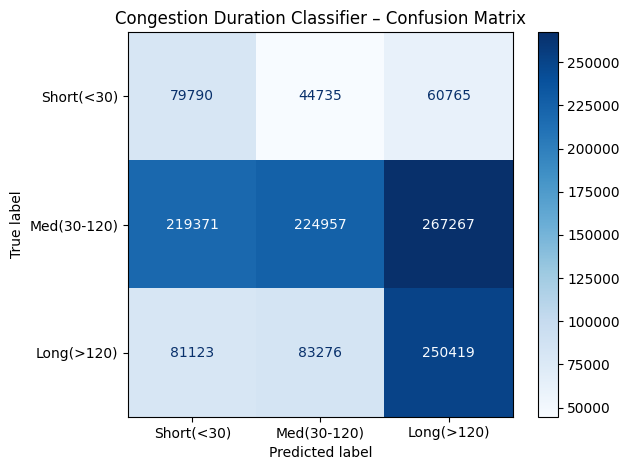

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["Short(<30)", "Med(30-120)", "Long(>120)"]

cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

plt.figure()
disp.plot(cmap="Blues", values_format="d")
plt.title("Congestion Duration Classifier – Confusion Matrix")
plt.tight_layout()
plt.show()


### Severity Prediction Model

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

severity_df = df.copy()
severity_df["Severe"] = (severity_df["Severity"] >= 3).astype(int)

X = severity_df.drop(columns=["Severity", "Log_Duration", "Duration_Class", "Severe"])
y = severity_df["Severe"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced" 
    ))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Save model
import joblib
joblib.dump(clf, "severity_model.pkl")


['severity_model.pkl']

In [72]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred, digits=3))


Accuracy: 0.8094309458772299
ROC AUC: 0.9413759076161257
              precision    recall  f1-score   support

           0      0.988     0.789     0.877   1133572
           1      0.412     0.940     0.573    178131

    accuracy                          0.809   1311703
   macro avg      0.700     0.865     0.725   1311703
weighted avg      0.910     0.809     0.836   1311703



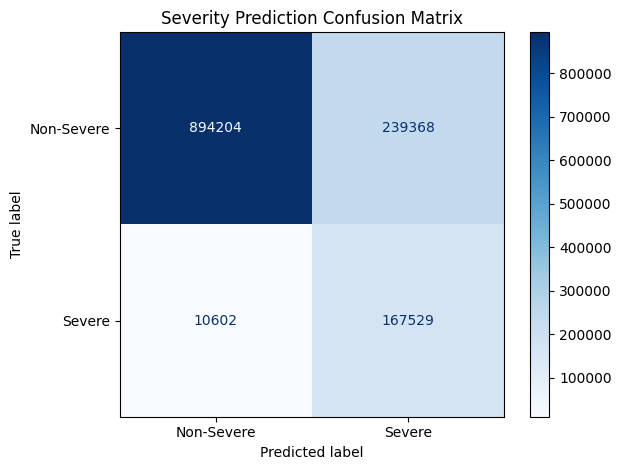

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["Non-Severe", "Severe"],
    cmap="Blues"
)

plt.title("Severity Prediction Confusion Matrix")
plt.tight_layout()
plt.show()


The severity classifier hits 81% accuracy with a strong ROC AUC of 0.94. This indicates the model is effective at distinguishing between severe and non-severe accidents. High recall is demonstrated for severe accidents, which means it meaningfully detects most truly sever incidents. However, this comes with lower precision, indicated many false positives. This tradeoff suggests a strong fit for risk-sensitive applications (e.g. self-driving, insurance) where missing a severe accident is costly, even if it means over-prediction.